In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from datetime import date
import re
import torch
import matplotlib.pyplot as plt
from pacmap import PaCMAP
from transformers import AutoTokenizer, AutoModel
import arxiv
from sklearn.neighbors import KNeighborsTransformer
from IPython.display import clear_output
torch.device('cpu')

device(type='cpu')

In [2]:
queries_of_interest = ['computer science', 'computational biology']

In [3]:

search = arxiv.Search(
  query = "computer science",
  max_results = 2,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

for result in search.results():
    print(result.categories)

['math.ST', 'math.PR', 'stat.TH']
['cs.CV', 'cs.LG', 'eess.IV']


In [4]:
def get_data(query,max_results):
    search = arxiv.Search(
      query = query,
      max_results = max_results,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    paper_data = []
    
    for result in search.results():
        category_vector = [result.categories[i] if i<len(result.categories) else "Nafin" for i in range(3)]
        
        
        abstract = result.summary.replace('\n',' ').replace('\\&','').replace('\\%','')
        
        temp = [result.title,result.published,abstract,result.pdf_url]
        temp.extend(category_vector)
        paper_data.append(temp)
        
    df = pd.DataFrame(data=paper_data, columns=['Title','Date', 'Abstract',"PDF URL",'Category1','Category2','Category3'])
    
    return df

In [5]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeddings(df):
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
    model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
    
    abstracts = df.Abstract.values
    abstracts = [str(a) for a in abstracts]
    
    encoded_input = tokenizer(abstracts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embeddings.numpy()

In [6]:
data = get_data("computer science",100)

In [7]:
embeddings = get_embeddings(data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:
embeddings.shape

(100, 768)

In [9]:
result = PaCMAP().fit_transform(embeddings)

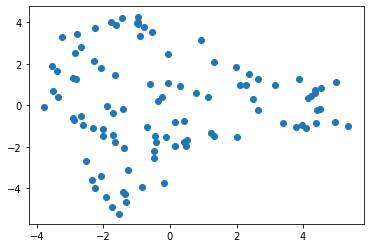

In [10]:
plt.scatter(result[:,0],result[:,1])

In [11]:
knt = KNeighborsTransformer(n_neighbors=3)
knt.fit(result)
A = knt.kneighbors_graph(result)

In [13]:
def make_training_data(data):
    i = 0
    y_vals = np.full(data.shape[0],-1)
    for i in range(data.shape[0]):
        print(data['Title'].values[i])
        print()
        print(data['Abstract'].values[i])
        val = input("Would you read this (1-Yes, 0-No, -1-Exit)")
        if val == "-1":
            break
        y_vals[i] = float(val)
        clear_output()
    return y_vals

In [22]:
col = make_training_data(data)

Feedback Vertex Set on Geometric Intersection Graphs

In this paper, we present an algorithm for computing a feedback vertex set of a unit disk graph of size $k$, if it exists, which runs in time $2^{O(\sqrt{k})}(n+m)$, where $n$ and $m$ denote the numbers of vertices and edges, respectively. This improves the $2^{O(\sqrt{k}\log k)}n^{O(1)}$-time algorithm for this problem on unit disk graphs by Fomin et al. [ICALP 2017]. Moreover, our algorithm is optimal assuming the exponential-time hypothesis. Also, our algorithm can be extended to handle geometric intersection graphs of similarly sized fat objects without increasing the running time.
Would you read this (1-Yes, 0-No, -1-Exit)-1


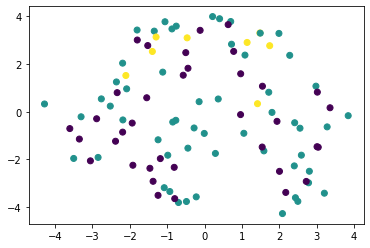

In [23]:
plt.scatter(result[:,0],result[:,1],c=col)

In [21]:
def show_closest_papers(df,embeddings,neighbors):
    titles,abstracts = df.Title.values, df.Abstract.values
    knt = KNeighborsTransformer(n_neighbors=neighbors,metric='cosine')
    knt.fit(embeddings)
    A = knt.kneighbors_graph(embeddings).toarray()
    
    
    for i in range(df.shape[0]):
        print("Paper to compare: ", titles[i])
        print()
        print(abstracts[i])
        
        print()
        
        print("Other Papers: ")
        print()
        
        v = A[i]
        close_titles = data.Title.values[(v==1)]
        print(close_titles)
        
        val = input(" (-1-Exit)")
        if val == "-1":
            break

        clear_output()

In [20]:
show_closest_papers(data,embeddings,5)

Paper to compare:  ViTGAN: Training GANs with Vision Transformers

Recently, Vision Transformers (ViTs) have shown competitive performance on image recognition while requiring less vision-specific inductive biases. In this paper, we investigate if such observation can be extended to image generation. To this end, we integrate the ViT architecture into generative adversarial networks (GANs). We observe that existing regularization methods for GANs interact poorly with self-attention, causing serious instability during training. To resolve this issue, we introduce novel regularization techniques for training GANs with ViTs. Empirically, our approach, named ViTGAN, achieves comparable performance to state-of-the-art CNN-based StyleGAN2 on CIFAR-10, CelebA, and LSUN bedroom datasets.

Other Papers: 

['ViTGAN: Training GANs with Vision Transformers'
 'ANCER: Anisotropic Certification via Sample-wise Volume Maximization'
 'Gradient-Based Quantification of Epistemic Uncertainty for Deep Obje

## Get Citations of Papers